In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings("ignore")

In [2]:
import McExperiment
from McExperiment import *
import importlib
importlib.reload(McExperiment)

<module 'McExperiment' from 'd:\\OneDriveLenovoD\\OneDrive\\A_Fall23\\FIN535\\HW2023\\FIN535-Final-23F\\Dec20\\FIN535-Final-23F\\McExperiment.py'>

In [3]:
data = pd.read_csv('data.csv')
data['month'] = data['month'].apply(lambda x: datetime.strptime(x, '%Y-%m')) #assume each date per month is the last day
data.set_index(['month'],inplace=True)

In [4]:
# read in optimal allocation from excel 
def read_excel_rst(n_strat=4):
    # return a table, row = objective, col = optimal allocation, and some critical stats
    ratios = []
    objs = []
    for i in range(n_strat): # for each objective, which corresponds to each sheet
        objs += [list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[[11,13,15,17,19],8].values.astype('f'))]
        ratio = list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[2,7:12].values.astype('f'))
        ratio[4] *= -1
        ratios += [ratio]
    opt_ratios = pd.DataFrame(ratios, index = ['max uti','max sharpe','max sortino','min mdd'], 
                  columns=['x1','x2','x3','x4','x5'])
    opt_objs = pd.DataFrame(objs, index = ['max uti','max sharpe','max sortino','min mdd'],\
                        columns = ['sharpe','mdd','uti','CE','sortino'])
    return pd.concat([opt_ratios, opt_objs],axis = 1)

n_strat=4
opt_excel_soln = read_excel_rst(n_strat)
opt_excel_soln

,x1,x2,x3,x4,x5,sharpe,mdd,uti,CE,sortino
max uti,0.181262,1.024393,0.750000,0.75,-0.205655,1.097224,0.250001,0.006363,12.076599,1.583711
max sharpe,0.490185,0.509815,0.342315,0.75,-0.000000,1.552223,0.250000,0.005783,12.069595,2.142872
max sortino,0.484227,0.515773,0.356543,0.75,-0.000000,1.551894,0.250000,0.005807,12.069884,2.143256
min mdd,0.463338,0.536662,0.280175,0.75,-0.000000,1.510296,0.196292,0.005592,12.067296,2.096605


#### Note:

excel results are quite different from the sim results because:
- sim is not a good method and has many cons
- max uti in sim result is max(cap after tax), excel is max mean(each log(1+simple return))
- sim result's sharpe and sortino did not minus risk-free in the numerator
- 

### Max log v-utility

In [5]:
SAVE = 40000
CAP = 50000
g = 0.11
MC = 500
path_length = 120 # 10 year

In [6]:
from tqdm import tqdm

In [8]:
Simu_table_lst = [] # simulated results before taking the avg
cap_table_lst = [] # for the financial diamond construction
Summary_table_lst = [] # after taking the avg of simulated results, then compute some critical stats

for i in tqdm(range(n_strat)):
    ratio = (opt_excel_soln.iloc[i,:5]).to_list()

    # Get the analysis for end of 5Y/7Y/10Y 
    Simu_table, Simu_cap_table = Experiments(MC,path_length,data,CAP,SAVE,g,ratio,years=[60,84,120],tax=0)
    Summary_table, cap_table = GetSummary(Simu_table, Simu_cap_table, path_length)
    Summary_table = Summary_table.fillna(0)
    Simu_table_lst += [Simu_table]
    cap_table_lst += [cap_table]
    Summary_table_lst += [Summary_table]

100%|██████████| 4/4 [01:32<00:00, 23.14s/it]


In [9]:
Summary_table_lst[0].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,429125.41,126525.97,369729.46,0.26,1.09,1.55,0.23,0.02,-0.07,-278478.24,-293705.44
7Y,802078.47,275525.00,444578.35,0.90,1.09,1.55,0.26,0.23,0.15,-114453.80,-144715.35
10Y,1768173.80,731623.81,0.00,1.00,1.07,1.52,1.59,0.63,0.43,192946.16,104981.40


#### Note:

MDD in the table above is on capital level, whereas in excel MDD is on return level

### Max Sharpe ratio

In [10]:
Summary_table_lst[1].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,409878.70,71643.04,393600.92,0.11,1.62,2.33,0.11,0.35,0.26,-221240.05,-240816.84
7Y,754636.35,143813.18,461965.00,0.98,1.63,2.33,0.12,0.72,0.53,-26250.38,-70837.69
10Y,1638333.89,360714.96,0.00,1.00,1.63,2.32,1.40,1.71,1.39,479976.41,441349.17


### Max Sortino Ratio

In [11]:
Summary_table_lst[2].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,403668.14,70391.49,390686.83,0.09,1.58,2.26,0.11,0.29,0.21,-237162.02,-243809.20
7Y,735986.28,145938.29,469008.86,0.96,1.58,2.25,0.11,0.67,0.47,-42995.83,-55277.35
10Y,1607575.08,375689.04,0.00,1.00,1.59,2.26,1.36,1.23,1.00,423758.34,312169.97


### Min max drawdown

In [12]:
Summary_table_lst[3].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,400633.11,69501.11,385174.88,0.10,1.58,2.26,0.11,0.35,0.16,-233035.55,-248712.31
7Y,717714.50,139772.74,472453.54,0.96,1.57,2.24,0.12,0.65,0.51,-35408.00,-60342.87
10Y,1528960.90,362620.47,0.00,1.00,1.56,2.22,1.31,1.11,0.99,387395.22,300999.82


## Financial Diamond

In [34]:
def get_loc(year_pts,cap_pts):
    # points coordinates follows the order of left up right down left(the last one is left is just to connect the points to draw a full diamond)
    x_coor = [year_pts[0],year_pts[1],year_pts[2],year_pts[1],year_pts[0]]
    y_coor = [cap_pts[1],cap_pts[2],cap_pts[1],cap_pts[0],cap_pts[1]]
    return x_coor, y_coor

year_pts = [4,5,6] # hard-coded for now, TODO
cap_pts_lst = [[cap_table_lst[i].iloc[3,0],cap_table_lst[i].iloc[4,0], cap_table_lst[i].iloc[5,0]] for i in range(3)] #if my interpretation of the diamond is correct

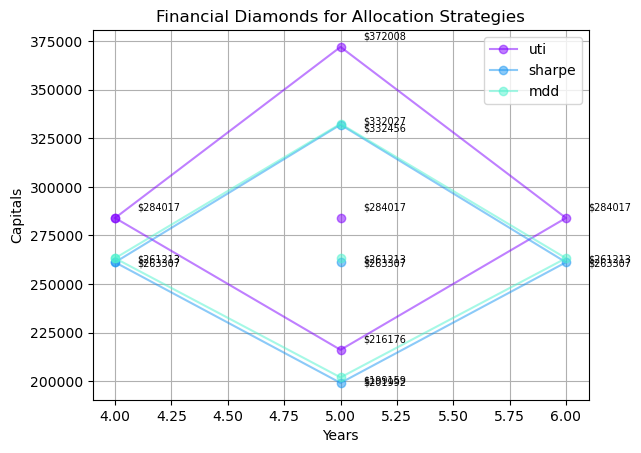

In [36]:
color = iter(cm.rainbow(np.linspace(0, 1, 6)))
labels = ['uti','sharpe','mdd']
fig, ax = plt.subplots()
for i in range(len(cap_pts_lst)):
    c = next(color)
    x_coor, y_coor = get_loc(year_pts,cap_pts_lst[i])
    ax.plot(x_coor, y_coor, '-o',alpha = 0.5, label=labels[i],c=c)
    ax.plot(x_coor[1], y_coor[0], '-o',alpha = 0.5,c=c)
    for j in range(len(x_coor)-1):
        # TODO: the location of the annotation will need to be changed so that they don't overlap
        ax.annotate(f'${round(y_coor[j])}', (x_coor[j]+0.1, y_coor[j]-4000*(i-1)),fontsize=7)
    ax.annotate(f'${round(y_coor[0])}', (x_coor[1]+0.1, y_coor[0]-4000*(i-1)),fontsize=7)
ax.legend()
ax.set_title('Financial Diamonds for Allocation Strategies')
ax.set_xlabel('Years')
ax.set_ylabel('Capitals')
ax.grid()